In [1111]:
import quspin as qs
import numpy as np
import matplotlib.pyplot as plt
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.operators import quantum_operator
import math
from quspin.basis import spin_basis_general
from matplotlib import colors
import random

In [1113]:
def intmatrix(Lx, J, xs=1, ys=1, theta=0, phi=0, Ly='_', plot=False, nn=False):
    # define side length of simulated system as L
    if Lx % 2 == 1:
        pass
    else:
        Lx += 1

    if Ly == '_':
        Ly = Lx
    else:
        if Ly % 2 == 1:
            pass
        else:
            Ly += 1
    
    mat = np.zeros((Lx, Ly))
    
    L_xrange, L_yrange = range(Lx), range(Ly)
    center_xindex = int(L_xrange[-1]/2)
    center_yindex = int(L_yrange[-1]/2)
    
    
    center = np.array([xs*center_xindex, ys*center_yindex, 0]) #position of matrix center (in 3D)
    
    quan_axis = [np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)] #quantization axis as an unit vector
    
    #Code for nearest neighbors
    if nn == True:
        if Lx == 1:
            L_xrange = [center_xindex]
        else:
            L_xrange = [center_xindex - 1, center_xindex, center_xindex + 1]

        if Ly == 1:
            L_yrange = [center_yindex]
        else:
            L_yrange = [center_yindex - 1, center_yindex, center_yindex + 1]
    
    for i in L_xrange:
        for j in L_yrange:
            displacement = np.array([xs*i, ys*j, 0]) - center
            r = np.linalg.norm(displacement)
            angle = np.arccos(displacement @ quan_axis/r)
            mat[i, j] = J*(1-3*(np.cos(angle)**2))/(r**3)
    mat[center_xindex, center_yindex] = 0.0

    if plot == True:
        fig, ax = plt.subplots()

        couplings = np.transpose(mat) #transpose to show x and y axis correctly (this will also switch x and y corrdinate ordering when indexing)

        cmap = plt.cm.RdBu
        ax.matshow(couplings, cmap=cmap, norm=colors.CenteredNorm())

        for i in range(len(couplings)):
            for j in range(len(couplings[0])): 
                c = '{:g}'.format(float('{:.2g}'.format(couplings[i, j])))
                #c = '(' + str(j) + ', ' + str(i) + ')'
                    
                ax.text(j, i, str(c), va='center', ha='center')
    
    return mat, Lx, Ly #indexing interaction matrix is done with mat[x coordinate, y coordinate]

def ran_occupied_sites(N, x, y): #dimensions of simulated lattice and no of particles to distribute
    total_sites = int(x*y)

    # Randomize which lattice sites are occupied
    occupied_sites = []
    free_sites = list(range(total_sites))
    
    for i in range(N):
        ran = random.randint(0, total_sites-i-1)
        #print('random int = ' + str(ran))
        occupied_sites.append(free_sites.pop(ran))
        
    return sorted(occupied_sites) #returns ordered list of N unique numbers between 0 and the total sites - 1 inclusive

def couples(sites, pairs, interactions, xy='_'):
    if xy == '_':    
        int_x, int_y = len(interactions)//2 + 1, len(interactions[0])//2 + 1 #dimensions of interaction matrix
    else:
        int_x, int_y = xy
    #use interaction matrix to get couplings between each occupied site and output this in the correct formatt with particle number
    couples = []
    for i in pairs:
        p1, p2 = sites[i[0]], sites[i[1]]
        
        couples.append([interactions[int_x - 1  + (p1 % int_x) - (p2 % int_x), int_y - 1 + (p1 // int_x) - (p2 // int_x)], i[0], i[1]]) 
    return couples

def symm_mat(x, y, occupied_sites, basis, axis=1): #defult finds mirror plane transformation which flips x coordinates
    #only relevent if lattice simulated has the symmetry which is tested on basis staes
    #occupied sites labelled left to right up to down in basis
    #for rectangular simulated systems (but sites occupied can be picked)

    symm = np.zeros((len(basis), len(basis)))
    count1 = 0
    asymmetrics = []
    flips = []
    for i in basis:
        basis_on_lattice = np.zeros((x, y))
        count2 = 0
        for n in i:
            if n == 1:
                basis_on_lattice[occupied_sites[count2] % x, occupied_sites[count2] // x] = 1

            count2 += 1

        flipped = np.flip(basis_on_lattice, axis)
        
        
        if flipped == basis_on_lattice:
            symm[count1, count1] = 1
        else:
            asymmetrics.append(basis_on_lattice)
            flips.append(flipped)
        count1 += 1

    for state in asymmetrics:
        pair = np.where(flips == state)[0]
        symm[pair[0], pair[1]], symm[pair[1], pair[0]] = 1, 1

    return symm

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_50443/453236352.py:43: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


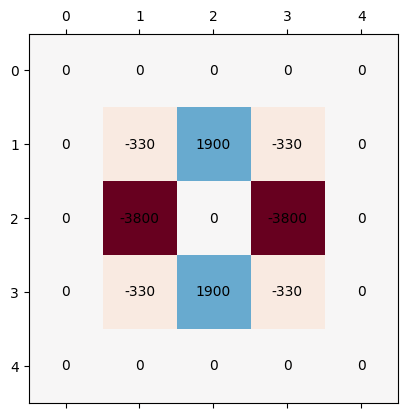

In [1115]:
fig, ax = plt.subplots()

Lx, Ly, J = 5, 5, 2*np.pi*300
theta, phi = 0, 2*np.pi/4

mat, xside, yside = intmatrix(Lx, J, Ly=Ly, theta=theta, phi=phi, nn=True)
couplings = np.transpose(mat)

cmap = plt.cm.RdBu
ax.matshow(couplings, cmap=cmap, norm=colors.CenteredNorm())

for i in range(len(couplings)):
    for j in range(len(couplings[0])):
        c = '{:g}'.format(float('{:.2g}'.format(couplings[i, j])))
        ax.text(j, i, str(c), va='center', ha='center')

In [1117]:
def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

def up_pop_plot(L, populations, values, dep_var):
    #basis = [r'0', r'1']
    #labels = [r'0', r'1']
    #for i in range(L - 1):
        #labels = str_tens(labels, basis)
    n_rows = len(populations[0])
    n_cols = len(populations[0][0])
    probs = [[matrix[i][j] for matrix in populations] for i in range(n_rows) for j in range(n_cols)]
    values = values*(10**3)    
    fig, axes = plt.subplots(1, 1)
    for i in range(L):
        axes.plot(values, probs[i], label=f'Particle {i+1}')
        
    #for i in range(5):
        #print(populations[:,1][100*i])

    axes.set_ylabel(r"Probability of detecting $\left|1\right>$", fontsize=20)
    axes.set_xlabel(dep_var, fontsize=20)
    axes.legend(loc=1, prop={'size': 14})

    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.set_yticks([0, 0.5, 1]) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_1+5_NearestNeighbors.png', bbox_inches='tight')
    
    plt.show(block=False)

In [1119]:
#define pulse sequences
def pulse_ramsey(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    elif t < pulse_time + free_time:
        return 0 
    elif t <= 2 * pulse_time + free_time:
        return rabi_frequency
    else:
        return 0

def pulse_single(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    else:
        return 0

def no_pulse(t, pulse_time, free_time, rabi_frequency):
    return 0

In [1121]:
pulse_time = 0.0478e-3 # in s
free_time = 15000 * pulse_time # 0.6e-3 # in s
rabi_frequency = 2*np.pi*(1/pulse_time)/4 # From RbCs Ramsey Paper https://doi.org/10.1088/2058-9565/aaee35 Figure 7
print((pulse_time*rabi_frequency)/(np.pi/2)) # Check pulse time and rabi frequency give a pi/2 pulse area 

0.9999999999999999


reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
[[   0.+0.j    0.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j 1000.+0.j    0.+0.j]
 [   0.+0.j 1000.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j    0.+0.j    0.+0.j]]


/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_50443/453236352.py:43: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


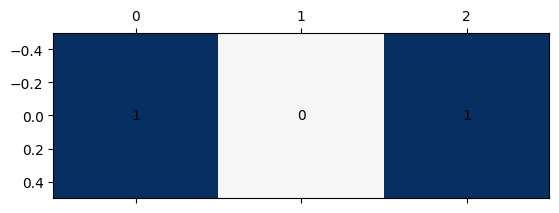

In [1139]:
L = 2

J = 1000#/(np.pi*np.sqrt(2)) #Hz
det = 0 #detuning
ax, ay = 1, 1 #lattice seperation in x and y directions  AX MAY BE SET AS AN AXIS LATER RATHER THAN THIS VALUE
row_len, Ly = L, 1 #Number of sites per row in lattice, NOTE row_len = Lx

params = [pulse_time, free_time, rabi_frequency]

def construct_H(N, J, det, ax, ay, Lx, params, pulse, theta=0, phi=0, Ly='_', int_plot=False, nn=False):
    basis = spin_basis_general(N=N, pauli=False)
    print(basis)
    if Ly == '_':
        Ly = 1

    #construct interaction
    sites = range(N)
    pairs = [[i, k] for idx, i in enumerate(sites) for k in sites[idx + 1:]]
    
    #interaction strengths between each particle
    interaction_matrix, _, _ = intmatrix(Lx*2 - 1, 1, xs=ax, ys=ay, theta=theta, phi=phi, Ly=Ly*2 - 1, plot=int_plot, nn=nn) 
    #above outputs 3 variables (also set J=1 in this function as it xJ at the end anyway) 
    sites = ran_occupied_sites(N, Lx, Ly)
    
    intr = couples(sites, pairs, interaction_matrix)

    #construct resonant and detuning terms
    drive = [[1.0, i] for i in range(N)]
    detuning = [[1.0, i] for i in range(N)]

    operator_list_0 = [['z', detuning]]
    operator_list_1 = [['x', drive]]

    #print(intr)

    #construct full Hamiltonian
    interaction = [['+-', intr], ['-+', intr]]
    operator_dict = {'detuning': operator_list_0, 'drive': operator_list_1, 'interaction': interaction}
    H = quantum_operator(operator_dict, basis=basis)
    params_dict = dict(detuning=det, drive=(pulse, params), interaction=J)
    H_lmbda1 = H.tohamiltonian(params_dict)
    return H_lmbda1

H_lmb0 = construct_H(L, J, det, ax, ay, row_len, params, no_pulse, Ly=Ly, theta=0, phi=0, int_plot=True, nn=True)

print(np.array2string(H_lmb0.toarray(), suppress_small=True, formatter={'float': '{:0.4f}'.format}))


reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[ 0.        +0.j  1.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.70710678+0.j  0.        +0.j  0.        +0.j  0.70710678+0.j]
 [-0.70710678-0.j  0.        +0.j  0.        +0.j  0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j]]
['0.71|01$\\rangle$-0.71|10$\\rangle$', '|00$\\rangle$', '|11$\\rangle$', '0.71|01$\\rangle$+0.71|10$\\rangle$']
[0.7071067811865477, 0.0, 0.0, 0.7071067811865475]


/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_50443/453236352.py:43: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)
/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_50443/298260727.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  decomposed.append(float(np.inner(right_flip, i)))


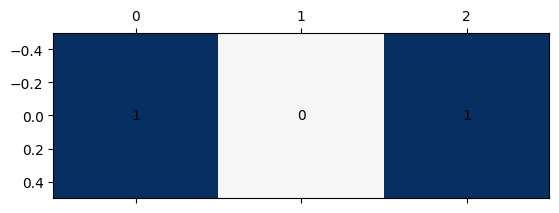

In [1141]:
#Computing eigenvalues and eigenvectors
eigen = True
if eigen == True:
    J1 = 10
    #Js = np.linspace(-J1, J1, 1000)
    Js = [1]
    energies = []
    for i in Js:
        H_i = construct_H(L, i, det, 1, 1, row_len, params, no_pulse, Ly=Ly, nn=True, int_plot=True)
        print(np.array2string(H_i.toarray(), suppress_small=True, formatter={'float': '{:0.4f}'.format}))
        val, vec = H_i.eigh()
        energies.append(val)
        
    print(vec)
    ket = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(L - 1):
        labels = str_tens(labels, ket)

    right_flip = np.zeros(2**L)
    right_flip[1] = 1
    decomposed = []
    
    fullvec = []
    for i in np.transpose(vec):
        decomposed.append(float(np.inner(right_flip, i)))
        count = 0
        lab = ''
        for n in i:
            if -0.01 < n < 0.01:
                pass
            else:
                #print(n)
                if n.imag == 0:
                    n = n.real
                    if n == 1 :
                        element = '+' + '|' + labels[count] + r'$\rangle$'
                    else:
                        element = '+' + '{:.2g}'.format(n) + '|' + labels[count] + r'$\rangle$'
                else:
                    element = '+' + '{:.2g}'.format(n) + '|' + labels[count] + r'$\rangle$'
                if n.real < 0 and lab != '':
                    element = element[1:]
                lab = lab + element
            count += 1
        fullvec.append(lab[1:])
    print(fullvec)
    
    energy = [[matrix[i] for matrix in energies] for i in range(len(energies[0]))]
       
    print(decomposed)

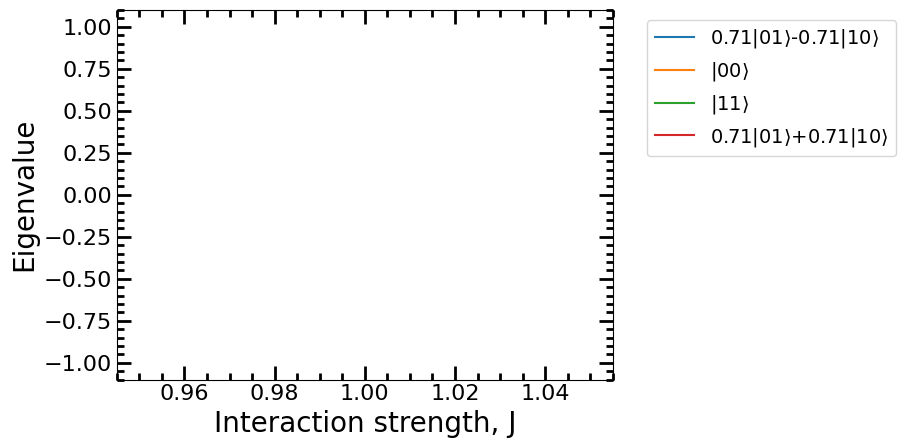

In [1143]:
if eigen == True:
    fig, axes = plt.subplots(1, 1)
    for i in range(len(fullvec)):
        axes.plot(Js, energy[i], label=fullvec[i])
            
        #for i in range(5):
            #print(populations[:,1][100*i])
    
    axes.set_ylabel(r"Eigenvalue", fontsize=20)
    axes.set_xlabel('Interaction strength, J', fontsize=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14})
    
    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_Eigenvectors.png', bbox_inches='tight')
        
    plt.show(block=False)

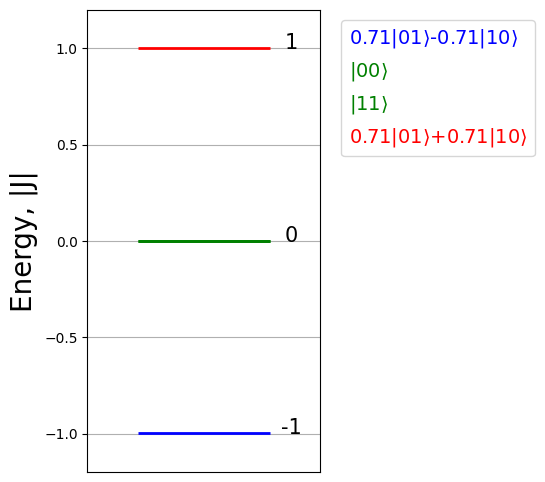

In [1144]:
if eigen == True:
    fig, ax = plt.subplots(figsize=(3, 6))
    
    for i in range(len(fullvec)):
        
        en = energy[i][0]
        if 0.05 < en:
            color = 'r'
        elif -0.05 < en < 0.05:
            color = 'g'
        else:
            color = 'b'
        ax.scatter(Js, en, s=9000, marker="_", linewidth=2, zorder=3, label=fullvec[i], color=color)
        #print(en)
        #print(color + '\n')
    ax.grid(axis='y')

    es = [energy[0][0], 0, energy[-1][0]]
    if L == 3:
        la = [r'-$\sqrt{2}$', 0, r'$\sqrt{2}$']   #3 particles
    elif L == 2:
        la = [-1, 0, 1]        #2 particles
    elif L == 4:
        la = es
    count = 0
    for i in es :
        ax.annotate(la[count], xy=(1.04,i+0.1), xytext=(7,-3), size=15,
                ha="center",va='top', textcoords="offset points")
        count += 1
    
    ax.margins(0.1)
    
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14}, labelcolor='linecolor', handlelength=0, handletextpad=0)
    
    for lh in leg.legend_handles:
        lh.set_alpha(0)
    
    ax.set_xticks([])
    plt.ylabel('Energy, |J|', fontsize=20)

    plt.savefig(f'E_Levels_{L}_particles_NearestNeighbors_.pdf', bbox_inches='tight')

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


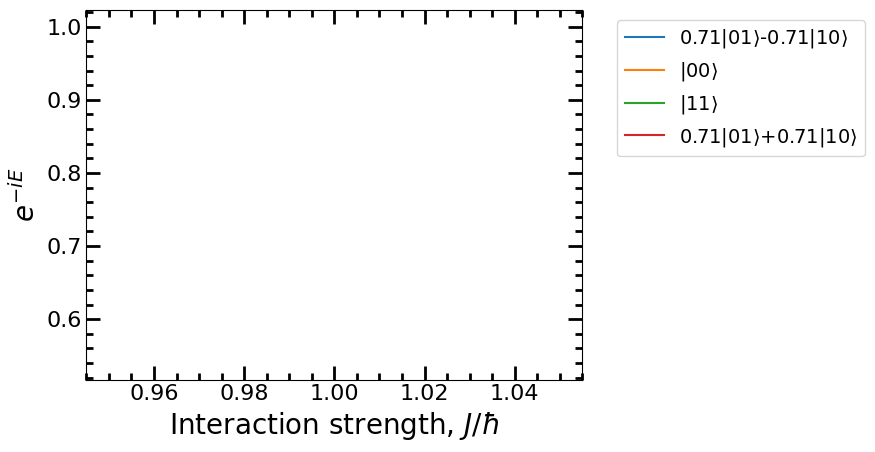

In [1147]:
#exp( -i*E/hbar ) graph for each eigenvector (depends on previous cell)
if eigen == True:
    fig, axes = plt.subplots(1, 1)
    energy = np.array(energy)
    for i in range(len(fullvec)):
        axes.plot(Js, np.exp(-1j*energy[i]), label=fullvec[i])
            
        #for i in range(5):
            #print(populations[:,1][100*i])
    
    axes.set_ylabel(r"$e^{-iE}$", fontsize=20)
    axes.set_xlabel(r'Interaction strength, $J/\hbar$', fontsize=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14})
    
    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Eigenvectors_Exponentials.png', bbox_inches='tight')
        
    plt.show(block=False)

In [1149]:
eigenvectors  = np.transpose(vec)
print(vec[:,2])
print(spin_basis_general(N=L, pauli=False))

[0.+0.j 0.+0.j 0.+0.j 1.+0.j]
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 


In [1151]:
#for labelling graphs
def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
(0.0005710021048641917+0.023888135360506903j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
(0.00517686888920447+0.07175816895565913j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
(0.01436140102237119+0.11896408079644263j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
(0.02803959415630611+0.1650689756970983j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1> 

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_50443/453236352.py:43: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


(0.41254825958890085+0.4921985494303569j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
(0.460249042616507+0.498313230351466j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
(0.5083166611727352+0.49981589760440037j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
(0.5563062362868076+0.4966926448330076j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 
Hermiticity check passed!
Symmetry checks passed!
(0.6037736091125592+0.48897237778542296j)
reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1

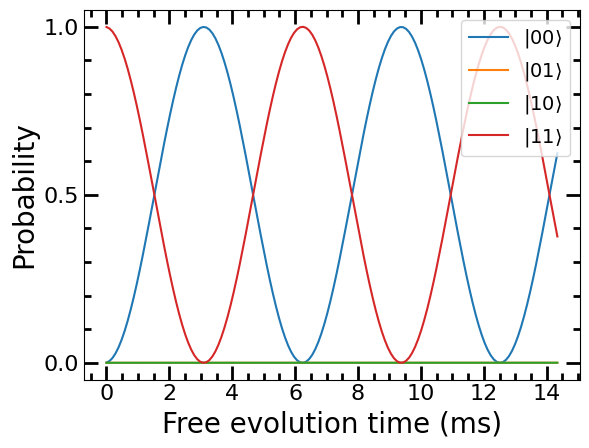

In [1155]:
rams = True
if rams == True:
    intervals = 150
    holds = np.linspace(0, 300 * pulse_time, intervals)

    psi_0 = np.zeros(2**L)
    psi_0[0] = 1 
    probs = []
    for free_time in holds:
        params = [pulse_time, free_time, rabi_frequency]
        H_lmb = construct_H(L, J, 0, 1, 1, row_len, params, pulse_ramsey)
        times = np.linspace(0, 2*pulse_time + free_time, 10)
        populations = H_lmb.evolve(psi_0, 0, times)
        print(populations[0][-1])
        probs.append([abs(populations[0][-1])**2, abs(populations[1][-1])**2, abs(populations[2][-1])**2, abs(populations[3][-1])**2])


    ket = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(L - 1):
        labels = str_tens(labels, ket)
    fig, axes = plt.subplots(1, 1)
    for i in range(2**L):
        axes.plot(holds*(10**3), [row[i] for row in probs], label='|' + labels[i] + r'$\rangle$')
        
        #for i in range(5):
            #print(populations[:,1][100*i])

    axes.set_ylabel(r"Probability", fontsize=20)
    axes.set_xlabel('Free evolution time (ms)', fontsize=20)
    axes.legend(loc=1, prop={'size': 14})

    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.set_yticks([0, 0.5, 1]) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_ramsey.png', bbox_inches='tight')
    
    plt.show(block=False)


In [1103]:
intervals = 1000
times = np.linspace(0, 0.01, intervals)
psi_0 = np.zeros(2**L)
#psi_0 = (vec[:,5] + vec[:,2])/np.sqrt(2)

psi_0[1] = 1  
#psi_0[16] = 1  #only middle spin spin up

if L == 3:
    #initial state as sum of eigenstates
        #set eignestate sum with decomposed
    decomposed = [0, 0, 0, 0, 1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]
    #decomposed = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2), 0, 0, 0, 0]
    psi_0 = np.zeros(2**L)
    c = 0
    for i in np.transpose(vec):
        psi_0 = psi_0 + i*decomposed[c]
        c += 1
    print(psi_0)

ket = [r'0', r'1']
labels = [r'0', r'1']
for i in range(L - 1):
    labels = str_tens(labels, ket)
    
populations = H_lmb0.evolve(psi_0, 0, times)
print(len(populations))

#fig, axes = plt.subplots(1, 1)
#for i in range(len(populations)):    
    #axes.plot(times, abs(populations[i])**2, label='|' + labels[i] + r'$\rangle$')
#plt.legend()
#plt.show

[ 0.        +0.j  0.85355339+0.j  0.5       +0.j  0.        +0.j
 -0.14644661+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
8


In [1105]:
def up_prob(L, row_len, populations):
    basis = spin_basis_general(N=L, pauli=False)
    col_len = int(math.ceil(L/row_len))

    #contruct outer product of single particle up spin state operator to find the probability it is in up
    outer_products = []
    for i in range(L):
        factors = [[[0.5, i]], [[-1, i]]]
        opers = [['I', factors[0]], ['z', factors[1]]]
        input_dict = {'up': opers}
        outer_products.append(quantum_operator(input_dict, basis=basis))
        #__ = quantum_operator(input_dict, basis=basis).tohamiltonian()
        #print(__.toarray())


    #calculate the probability each particle is spin up for each time evolved
    results = []
    for i in np.transpose(populations):
        probs = np.zeros((col_len, row_len))
        for n in range(L):
            if n==4:
                print(outer_products[n].expt_value(i))
            probs[n//row_len][n%row_len] = outer_products[n].expt_value(i)
        results.append(probs)

    #print(results)
    return results

results = up_prob(L, row_len, populations)
    

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_50443/1076318461.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[n//row_len][n%row_len] = outer_products[n].expt_value(i)


In [1107]:
#plot result matricies
from mpl_toolkits.axes_grid1 import ImageGrid

if intervals <= 64:

    dims = int(math.ceil(np.sqrt(len(results))))

    fig = plt.figure(figsize=(1.5*dims, 1.5*dims))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(dims, dims),  # creates grid of Axes
                     axes_pad=0.3,  # pad between Axes in inch.
                     )

    count = 0
    for ax in grid:
        # Iterating over the grid returns the Axes.
        cax = ax.matshow(results[count])
        cax.set_clim(0, 1)
    
        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('{:g}'.format(float('{:.3g}'.format(times[count]*(10**3)))) + 'ms')
        count += 1

    cbar = fig.colorbar(cax, location="right", 
            shrink=0.5,
            aspect=30,
            fraction=0.5,
            anchor=(1.1,0.5))

    cbar.ax.set_ylabel('Probability of detecting spin up state', fontsize=16)
    plt.savefig(f'Small_energy_gap_Eigenstates_{L}_particles_NearestNeighbors_J={J}.pdf', bbox_inches='tight')
    plt.show()
else:
    pass




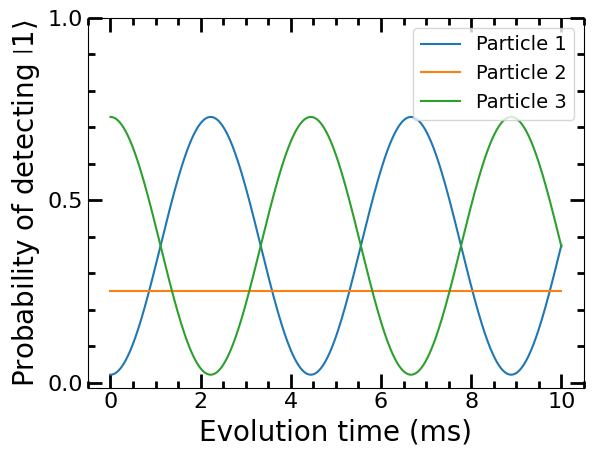

In [1109]:
if intervals >= 100:
    up_pop_plot(L, results, times, 'Evolution time (ms)')

In [1073]:
if intervals >= 100:
    x = times
    y = results
    
    ## fourier transform
    f = np.fft.fft(y)
    ## sample frequencies
    freq = np.fft.fftfreq(len(y), d=x[1]-x[0])
    plt.plot(times, results)

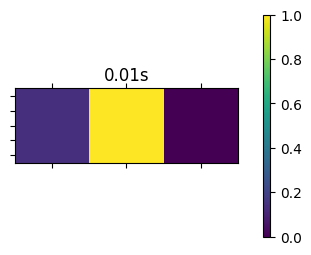

In [45]:
# animation
from matplotlib.animation import PillowWriter

metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=24, metadata=metadata)

fig, ax = plt.subplots()

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])


cbar.ax.set_ylabel('Probability of detecting spin up state')

with writer.saving(fig, f'{L}_particle_2D_spin.gif', 100):
    cax = ax.matshow(results[0])
    cax.set_clim(0, 1)
    cbar = fig.colorbar(cax, location="right", 
            shrink=0.6,
            aspect=30,
            fraction=0.5)
    count = 0
    for i in results[0:]:
        ax.clear()
        ax.set_title('{:g}'.format(float('{:.3g}'.format(times[count]))) + 's')
        cax = ax.matshow(i)
        writer.grab_frame()
        count += 1
        
    

In [445]:
v = -3.6546
print('{:.2g}'.format(v))

-3.7
